In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, precision_recall_fscore_support
from xgboost import XGBClassifier

In [32]:
df = pd.read_csv('data_final.csv')

df.drop(columns=['Scientific Name', 'Country'], axis=1, inplace=True)

X = df.drop(columns='Conservation Status')
y = df['Conservation Status']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=64)
#train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=64)

#convert conservation status to int
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [33]:
#Hyperparameter Tuning
param_grid = {
    'n_estimators': [300, 500, 800, 1200], #number of trees
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 7], #depth of trees
    'min_child_weight': [1, 2, 3, 5], #data points present in each node of tree
    'subsample': [0.6, 0.7, 0.8, 1.0], #number of observations used build each tree (larger = more complex)
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0], #number of features used to build tree
    'reg_alpha': [0, 0.01, 0.1, 1, 10, 100], #strength of L1 regularization (if some features are more relevant than others) larger value = less overfitting
    'reg_lambda': [0.5, 0.7, 1, 1.3], #strength of L2 regularization (if features have equal importance)
    'scale_pos_weight': [0.5, 1, 2, 5, 10],
    'gamma': [0, 0.1, 0.5, 1, 5]
}

xgb_model = xgb.XGBClassifier(random_state=64)

f1_macro = make_scorer(f1_score, average='macro')

grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=10, scoring=f1_macro, n_iter=300, n_jobs=-1, verbose=2, random_state=64)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

#Best parameters from tuning
print("best parameters: ", grid_search.best_params_)
print("best f1: ", grid_search.best_score_)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


C:\Users\bryce\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [01:32:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


best parameters:  {'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 1.3, 'reg_alpha': 0.01, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.005, 'gamma': 0.5, 'colsample_bytree': 1.0}
best f1:  0.6005062846510215


In [34]:
y_pred = best_xgb.predict(X_test)

test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"test f1: {test_f1:.4f}")

print("\nclassification report: \n", classification_report(y_test, y_pred))

test f1: 0.5571

classification report: 
               precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.33      0.33      0.33         3
           2       0.81      0.88      0.84        24
           3       0.25      0.24      0.24        17

    accuracy                           0.56        62
   macro avg       0.48      0.49      0.48        62
weighted avg       0.55      0.56      0.56        62



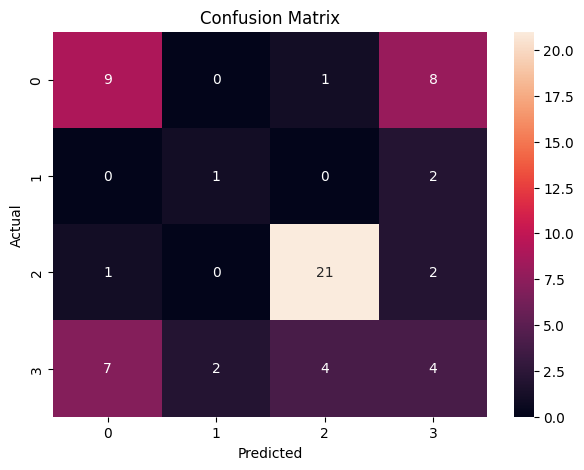

In [35]:
#confusion matrix
cm=confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

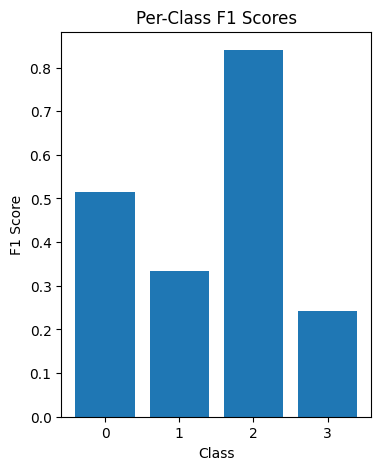

In [36]:
#per-class f1 bar chart
_, _, f1s, _ = precision_recall_fscore_support(y_test, y_pred)

plt.figure(figsize=(4,5))
plt.bar(range(len(f1s)), f1s)
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores")
plt.show()

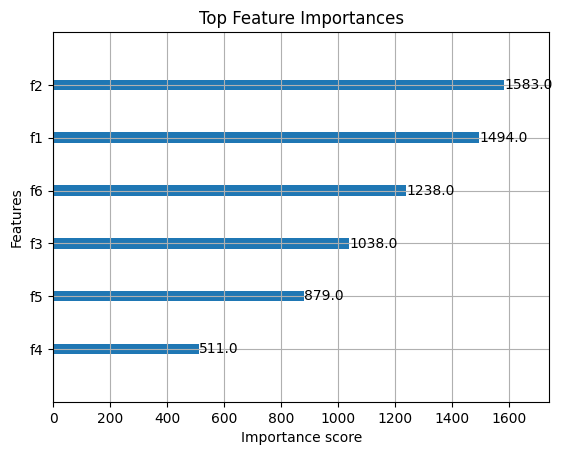

In [37]:
#feature importance plot
xgb.plot_importance(best_xgb, max_num_features=20)
plt.title("Top Feature Importances")
plt.show()

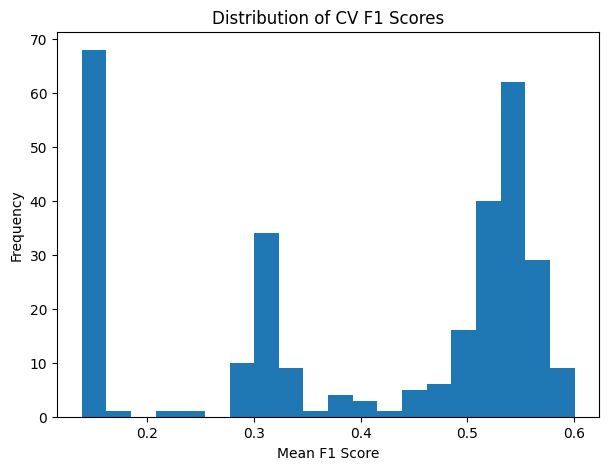

In [38]:
#cross validation score distribution
cv_scores = grid_search.cv_results_["mean_test_score"]
plt.figure(figsize=(7,5))
plt.hist(cv_scores, bins=20)
plt.xlabel("Mean F1 Score")
plt.ylabel("Frequency")
plt.title("Distribution of CV F1 Scores")
plt.show()